In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy

import mne 
import mne_bids

from smooth import *

In [2]:
# set different path to load and save data
ds_root='../data/preprocessData'
tgt_dir='..'

# BIDS format file name part labels
BIDS_fn_label = []
BIDS_fn_label.append('_task-randomDot')      # BIDS file name task label. format: [_task-<task_label>]
BIDS_fn_label.append('_eeg')           # BIDS file name modality suffix. format: [_eeg\meg\bold]

# make folders to save result
result_dir_epoch=os.path.join(tgt_dir,'results','epoch')
if not os.path.exists(result_dir_epoch):
    os.makedirs(result_dir_epoch)

result_dir_erp=os.path.join(tgt_dir,'results','erp')
if not os.path.exists(result_dir_erp):
    os.makedirs(result_dir_erp)

result_dir_joint_modeling=os.path.join(tgt_dir,'results','joint-modeling')
if not os.path.exists(result_dir_joint_modeling):
    os.makedirs(result_dir_joint_modeling)


In [ ]:
# extract parameters for ddm
sampleRate = 500
# EEG epoch parameters
tmin = -1
tmax = 0.2
time4baseline=(-1,-0.8)
channel_indices = [54, 36, 86]
channel_indices4ddm = channel_indices

# set time parameters: ams and slps(-0.018, 0.08); pams(-0.05,0.05)
t4ams_slps_first = -0.018
t4ams_slps_last = 0.08
t4pams_first = -0.05
t4pams_last = 0.05

data_erp4whole = [] 
joint_result_all = [] # prepare for ams, pams and slps

#20个成年人
sub_dir=[f'sub-A{i:03d}' for i in range(1,21)]
for sub in sub_dir:

    # load EEG data and corresponding triggers
    raw=mne.io.read_raw_brainvision(os.path.join(ds_root,sub,'eeg',sub+BIDS_fn_label[0]+BIDS_fn_label[1]+'.vhdr'))
    trigger, trigger_id = mne.events_from_annotations(raw)
    trigger_id4response = 'Stimulus/S  5'  

    trigger_response = trigger[trigger[:, 2] == trigger_id[trigger_id4response]]
    trigger_response_id = {trigger_id4response: trigger_id[trigger_id4response]}


    # epoch eeg data
    data_epochs = mne.Epochs(raw, trigger, event_id=trigger_response_id,
                                             tmin=tmin, tmax=tmax, baseline=time4baseline, preload=True)
    data_epochs4save = data_epochs.get_data() 

    # extract erp(cpz, cp1, cp2)
    data_epoch_erp = data_epochs.get_data(picks=channel_indices)  # shape: (trials, 3, n_times)
    data_epoch_erp_averaged = np.nanmean(data_epoch_erp, axis=(0, 1))  # shape: (n_times,)
    data_epoch_erp_averaged = data_epoch_erp_averaged/1e6 # turn to V instead of µV
    data_erp4whole.append(data_epoch_erp_averaged)

     # save eeg data
    data_epoch_save={
        "EEG_epoch":data_epochs4save
    }
    save_epoch=os.path.join(result_dir_epoch,'epoch_'+sub+'.mat')
    scipy.io.savemat(save_epoch, data_epoch_save)

    #save erp data
    data_erp_save={
        'erp':data_epoch_erp
    }
    save_erp=os.path.join(result_dir_erp,'erp_'+sub+'.mat')
    scipy.io.savemat(save_erp, data_erp_save )

    #########
    #extract ams, pams and spls for joint-modeling (the epoch is defined 100ms before making response)
    # data for ams
    epochs4ddm_ams = mne.Epochs(raw, trigger, event_id=trigger_response_id,
                                tmin=t4ams_slps_first, tmax=t4ams_slps_last, baseline=None, preload=True)
    data_epochs4ddm_ams = epochs4ddm_ams.get_data(picks=channel_indices4ddm) 
    data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))

    # data for pams
    epochs4ddm_pams = mne.Epochs(raw, trigger, event_id=trigger_response_id,
                                 tmin=t4pams_first, tmax=t4pams_last, baseline=None, preload=True)
    data_epochs4ddm_pams = epochs4ddm_pams.get_data(picks=channel_indices4ddm) 
    data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))

    # data for slps
    epochs4ddm_slps = mne.Epochs(raw, trigger, event_id=trigger_response_id,
                                tmin=t4ams_slps_first, tmax=t4ams_slps_last, baseline=None, preload=True)
    data_epochs4ddm_slps = epochs4ddm_slps.get_data(picks=channel_indices4ddm) 
    data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
    data_epochs4ddm_slps_averaged = pd.DataFrame(data_epochs4ddm_slps_averaged)
    smooth(data_epochs4ddm_slps_averaged, epoch_time=51, sample_rate=500)

    # set empty dataset
    ams = np.empty((data_epochs4ddm_ams_averaged.shape[0],1))
    pams = np.empty((data_epochs4ddm_pams_averaged.shape[0],1))
    slps = np.empty((data_epochs4ddm_slps_averaged.shape[0],1))

    for i in range(data_epochs4ddm_ams_averaged.shape[0]):

        data_perTrial_ams = data_epochs4ddm_ams_averaged[i,:]

        ams_mean = np.nanmean(data_perTrial_ams)
        ams[i,0] = ams_mean

    for i in range(data_epochs4ddm_pams_averaged.shape[0]):

        data_perTrial_pams = data_epochs4ddm_pams_averaged[i,:]

        pams_mean = np.nanmax(data_perTrial_pams)
        pams[i,0] = pams_mean

    for i in range(data_epochs4ddm_slps_averaged.shape[0]):
        data_perTrial_slps = data_epochs4ddm_slps_averaged.iloc[i,:]

        x = np.arange(len(data_perTrial_slps)) * (1/sampleRate)  # 转换为秒
        y = data_perTrial_slps
        slps[i, 0] = np.polyfit(x, y, 1)[0] 
    
    joint_result = np.column_stack((ams, pams, slps))
    joint_result_withHeader = pd.DataFrame(joint_result, columns=['ams', 'pams', 'slps'])
    joint_result_withHeader['subj'] = sub

    joint_result_all.append(joint_result_withHeader)



Extracting parameters from ../data/preprocessData/sub-A001/eeg/sub-A001_task-randomDot_eeg.vhdr...


Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
312 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 312 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 50 original time points ...
0 bad epochs dropped
Extracting par

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Loading data for 321 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Loading data for 321 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Loading data for 321 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A004/eeg/sub-A004_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
321 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A006/eeg/sub-A006_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
318 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Loading data for 320 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Loading data for 320 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Loading data for 320 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A008/eeg/sub-A008_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
324 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)


0 bad epochs dropped
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
Loading data for 324 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
Loading data for 324 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
Loading data for 324 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A009/eeg/sub-A009_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
322 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A010/eeg/sub-A010_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Loading data for 320 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Loading data for 320 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
320 matching events found
No baseline correction applied
0 projection items activated
Loading data for 320 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A011/eeg/sub-A011_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
324 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))


0 bad epochs dropped
Not setting metadata
323 matching events found
No baseline correction applied
0 projection items activated
Loading data for 323 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
323 matching events found
No baseline correction applied
0 projection items activated
Loading data for 323 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
323 matching events found
No baseline correction applied
0 projection items activated
Loading data for 323 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A013/eeg/sub-A013_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
301 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Loading data for 301 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Loading data for 301 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Loading data for 301 events and 50 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/sub-A014/eeg/sub-A014_task-randomDot_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6')]
Not setting metadata
324 matching events found
Applying baseline correction (mode: mean)
0 pro

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 50 original time points ...
0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
322 matching events found
No baseline correction applied
0 projection items activated
Loading data for 322 events and 50 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:63: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_ams_averaged = np.nanmean(data_epochs4ddm_ams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:69: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_pams_averaged = np.nanmean(data_epochs4ddm_pams, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:75: RuntimeWarning: Mean of empty slice
  data_epochs4ddm_slps_averaged = np.nanmean(data_epochs4ddm_slps, axis=(1))
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:88: RuntimeWarning: Mean of empty slice
  ams_mean = np.nanmean(data_perTrial_ams)
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/3934441909.py:95: RuntimeWarning: All-NaN slice encountered
  pams_mean = np.nanmax(data_perTrial_pams)


In [11]:
#save joint-modeling
joint_modeling_final = pd.concat(joint_result_all, axis=0, ignore_index=True)

joint_modeling_final.insert(loc=4, column='slp_quantile', value=joint_modeling_final.groupby(['subj']).slps.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))
joint_modeling_final.insert(loc=4, column='am_quantile', value=joint_modeling_final.groupby(['subj']).ams.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))
joint_modeling_final.insert(loc=4, column='pam_quantile', value=joint_modeling_final.groupby(['subj']).pams.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))

# Normalize the features by subject and coherence (subtract the mean and divide by the standard deviation within each group)
joint_modeling_final['ams'] = joint_modeling_final.groupby(['subj']).ams.transform(lambda x: (x - x.mean()) / x.std())
joint_modeling_final['slps'] = joint_modeling_final.groupby(['subj']).slps.transform(lambda x: (x - x.mean()) / x.std())
joint_modeling_final['pams'] = joint_modeling_final.groupby(['subj']).pams.transform(lambda x: (x - x.mean()) / x.std())

# Bin the features based on quantiles and calculate the mean for each bin
# Bin the 'am' feature by 'am_quantile' and calculate the mean for each bin
mean_am = joint_modeling_final.groupby(['subj', 'am_quantile']).ams.mean().reset_index()
mean_am.rename(columns={'ams': 'am_bin'}, inplace=True)  # Rename the binned column
joint_modeling_final = pd.merge(joint_modeling_final, mean_am, on=['subj', 'am_quantile'], how='left')

# Bin the 'slp' feature by 'slp_quantile' and calculate the mean for each bin
mean_slp = joint_modeling_final.groupby(['subj', 'slp_quantile']).slps.mean().reset_index()
mean_slp.rename(columns={'slps': 'slp_bin'}, inplace=True)
joint_modeling_final = pd.merge(joint_modeling_final, mean_slp, on=['subj',  'slp_quantile'], how='left')

# Bin the 'pam' feature by 'pam_quantile' and calculate the mean for each bin
mean_pam = joint_modeling_final.groupby(['subj', 'pam_quantile']).pams.mean().reset_index()
mean_pam.rename(columns={'pams': 'pam_bin'}, inplace=True)
joint_modeling_final = pd.merge(joint_modeling_final, mean_pam, on=['subj',  'pam_quantile'], how='left')

joint_output_path = os.path.join(result_dir_joint_modeling,'joint_modeling_all.csv')
joint_modeling_final.to_csv(joint_output_path, index=False)


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/89842570.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_am = joint_modeling_final.groupby(['subj', 'am_quantile']).ams.mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/89842570.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_slp = joint_modeling_final.groupby(['subj', 'slp_quantile']).slps.mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_36909/89842570.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future v

In [4]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

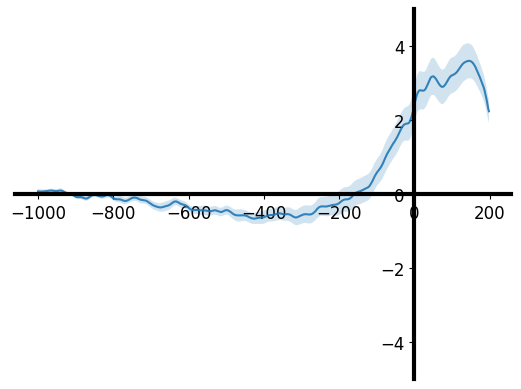

In [5]:
times = np.arange(-1000, 200, 1200/601)
plot_erp_results(data_erp4whole, times, ylim=[-5,5],labelpad=25)

In [2]:
all_erps = {}

In [5]:
a=()

In [6]:
b=[]